In [1]:
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
from textblob import TextBlob
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import text_processors
from progressbar import ProgressBar

plt.rcParams["figure.figsize"] = (10, 8)

stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [2]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [4]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [5]:
def score_model(X, y, pipeline):
    scores = cross_val_score(pipeline, X, y, cv=3, n_jobs=1, verbose=1)
    mean_score = np.mean(scores)
    std_dev_score = np.std(scores)
    print("CV score of {} +/- {}".format(mean_score, std_dev_score))

In [6]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.float64)  #for numerical progression
    # response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)  # for categorical response
    return features, response

In [7]:
def fit_and_submit(train_df, test_df, pipeline, filename):
    X_test, y_test = extract_features(test_df)
    X_train, y_train = extract_features(train_df)

    if vectorized_docs_train and feature_list:
        X_train = hstack([vectorized_docs_train[1], coo_matrix(X_train)])
        X_test = hstack([vectorized_docs_test[1], coo_matrix(X_test)])
        logPrint('Matrices combined')
    elif vectorized_docs_train and not feature_list:
        X_train = vectorized_docs_train[1]
        X_test = vectorized_docs_test[1]
    elif not vectorized_docs_train and feature_list:
        pass
    elif not vectorized_docs_train and not feature_list:
        print('whoops!')

    # predict the counts for the test set
    if feature_list:
        s1 = pipeline.fit(X_train[feature_list], y_train['score_lvl_1']).predict(X_test[feature_list])
        s2 = pipeline.fit(X_train[feature_list], y_train['score_lvl_2']).predict(X_test[feature_list])
        s3 = pipeline.fit(X_train[feature_list], y_train['score_lvl_3']).predict(X_test[feature_list])
    else:
        s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
        s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
        s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    predictions = np.dstack((s1, s2, s3))[0]

    # clip the predictions so they are all greater than or equal to zero
    # since we can't have negative counts of violations
    # SHOULD TRY CLIPPING AFTER AVERAGING SCORES ALSO
    predictions = np.clip(predictions, 0, np.inf)

    # averaging by mean, SHOULD TRY ALT METHODS OF GROUPING SCORES TOGETHER
    test_df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']] = predictions
    submission_scores = test_df.groupby(['restaurant_id', 'inspection_date', 'inspection_id'])['score_lvl_1', 'score_lvl_2', 'score_lvl_3'].mean()
    temp = submission_scores.reset_index().set_index('inspection_id')

    # write the submission file
    new_submission = data_grab.get_submission()
    indexed_prediction = temp.reindex(new_submission.index)
    if new_submission.shape != indexed_prediction.shape:
        logPrint("ERROR: Submission and prediction have different shapes")
    new_submission[['*', '**', '***']] = np.round(indexed_prediction[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]).astype(np.int8)
    new_submission.to_csv('predictions/'+filename)

In [8]:
import data_grab
train_df, test_df = data_grab.get_flats()

In [9]:
tdmax = train_df.time_delta.max()
tdmin = train_df.time_delta.min()
train_df['time_delta_bin'] = pd.cut(train_df["time_delta"], np.arange(tdmin, tdmax, 30))

In [10]:
X, y = extract_features(train_df)

In [11]:
data = pd.concat([X, y], axis=1)
scores = y[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]
transformed_y = pd.DataFrame(scores.multiply([1, 3, 5], axis=1).sum(axis=1), columns=['transformed_score'])
data['transformed_score'] = transformed_y


* Formula: transformed_score ~ C(restaurant_hours_friday_close) + C(restaurant_hours_friday_open) + C(restaurant_hours_monday_close) + C(restaurant_hours_monday_open) + C(restaurant_hours_saturday_close) + C(restaurant_hours_saturday_open) + C(restaurant_hours_sunday_close) + C(restaurant_hours_sunday_open) + C(restaurant_hours_thursday_close) + C(restaurant_hours_thursday_open) + C(restaurant_hours_tuesday_close) + C(restaurant_hours_tuesday_open) + C(restaurant_hours_wednesday_close) + C(restaurant_hours_wednesday_open)

* Formula: score_lvl_1 ~ C(restaurant_hours_friday_close) + C(restaurant_hours_friday_open) + C(restaurant_hours_monday_close) + C(restaurant_hours_monday_open) + C(restaurant_hours_saturday_close) + C(restaurant_hours_saturday_open) + C(restaurant_hours_sunday_close) + C(restaurant_hours_sunday_open) + C(restaurant_hours_thursday_close) + C(restaurant_hours_thursday_open) + C(restaurant_hours_tuesday_close) + C(restaurant_hours_tuesday_open) + C(restaurant_hours_we

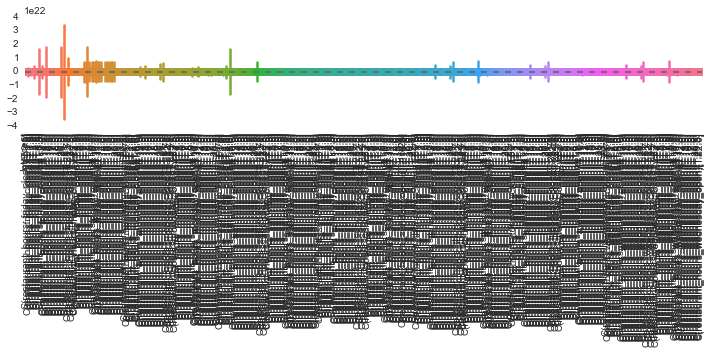

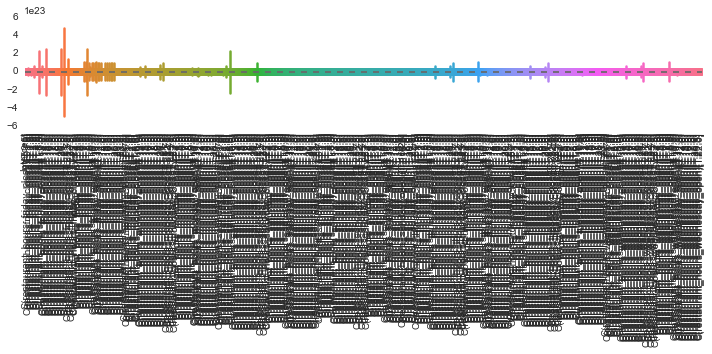

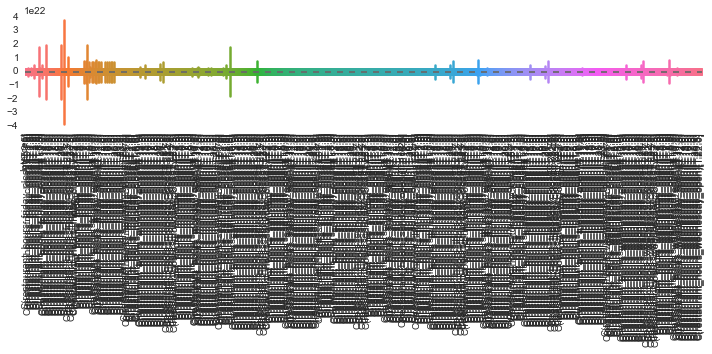

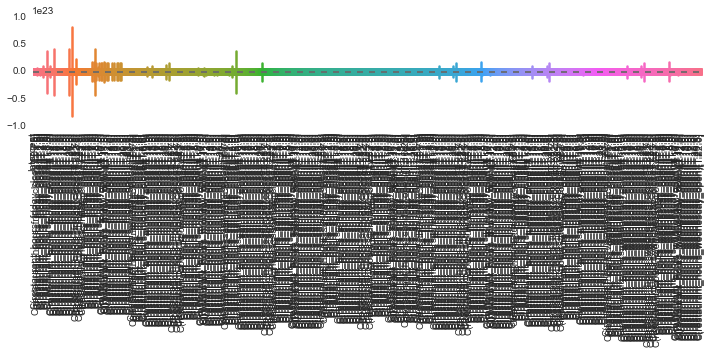

In [269]:
hours = X[['restaurant_hours_friday_close',
 'restaurant_hours_friday_open',
 'restaurant_hours_monday_close',
 'restaurant_hours_monday_open',
 'restaurant_hours_saturday_close',
 'restaurant_hours_saturday_open',
 'restaurant_hours_sunday_close',
 'restaurant_hours_sunday_open',
 'restaurant_hours_thursday_close',
 'restaurant_hours_thursday_open',
 'restaurant_hours_tuesday_close',
 'restaurant_hours_tuesday_open',
 'restaurant_hours_wednesday_close',
 'restaurant_hours_wednesday_open',]]
sns.mpl.rc("figure", figsize=(8,10))
X_formula = " + ".join(['C({})'.format(i) for i in hours.columns.tolist()])

scores = ['transformed_score', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/opening_closing_hours_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))


* Formula: transformed_score ~ restaurant_attributes_accepts_credit_cards + restaurant_attributes_ages_allowed + restaurant_attributes_alcohol + restaurant_attributes_attire + restaurant_attributes_byob + restaurant_attributes_byob_corkage + restaurant_attributes_by_appointment_only + restaurant_attributes_caters + restaurant_attributes_coat_check + restaurant_attributes_corkage + restaurant_attributes_delivery + restaurant_attributes_dietary_restrictions_dairy_free + restaurant_attributes_dietary_restrictions_gluten_free + restaurant_attributes_dietary_restrictions_halal + restaurant_attributes_dietary_restrictions_kosher + restaurant_attributes_dietary_restrictions_soy_free + restaurant_attributes_dietary_restrictions_vegan + restaurant_attributes_dietary_restrictions_vegetarian + restaurant_attributes_dogs_allowed + restaurant_attributes_drive_thr + restaurant_attributes_good_for_dancing + restaurant_attributes_good_for_groups + restaurant_attributes_good_for_breakfast + restaurant

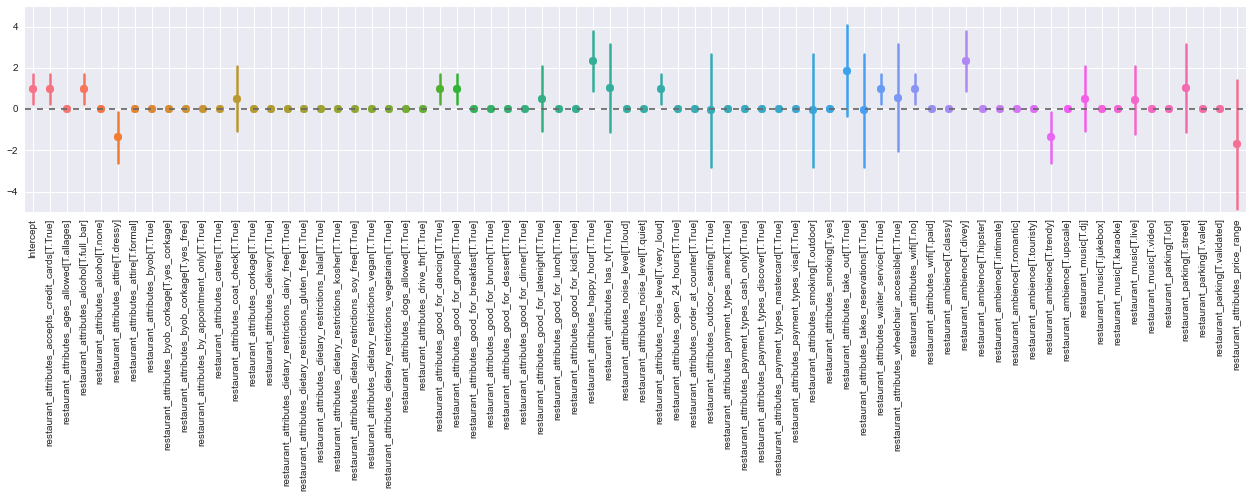

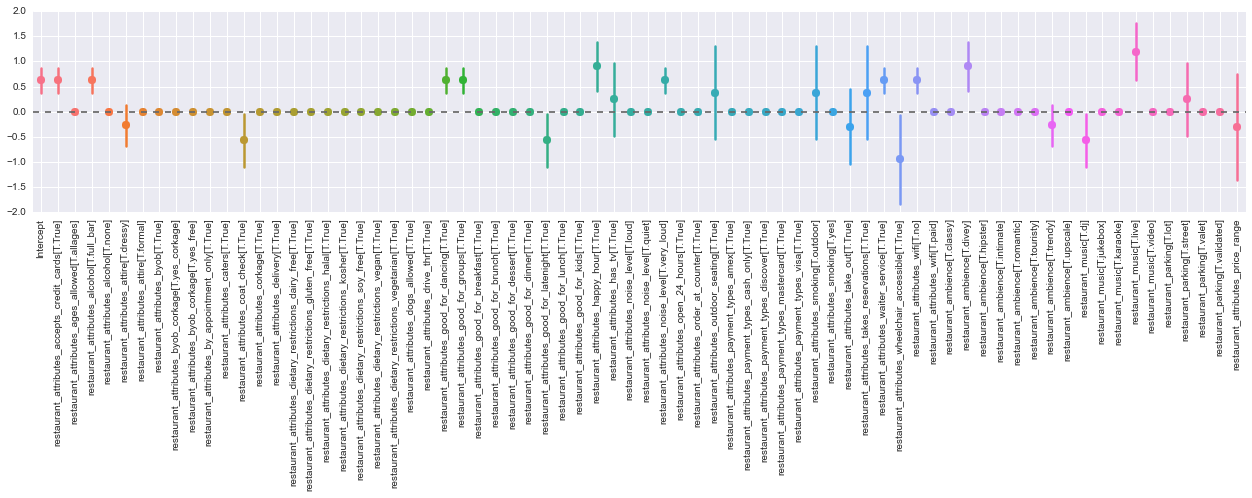

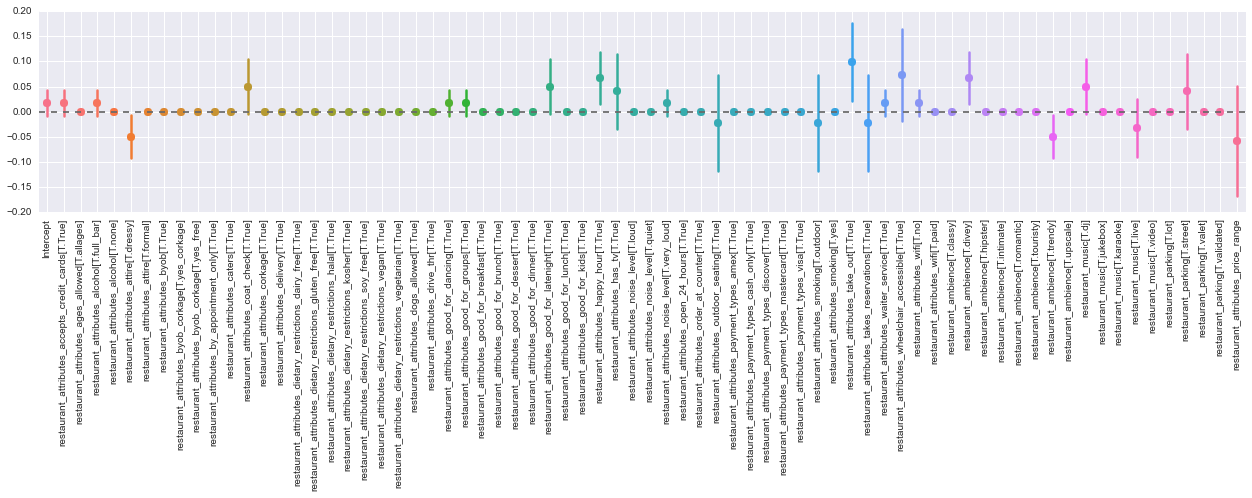

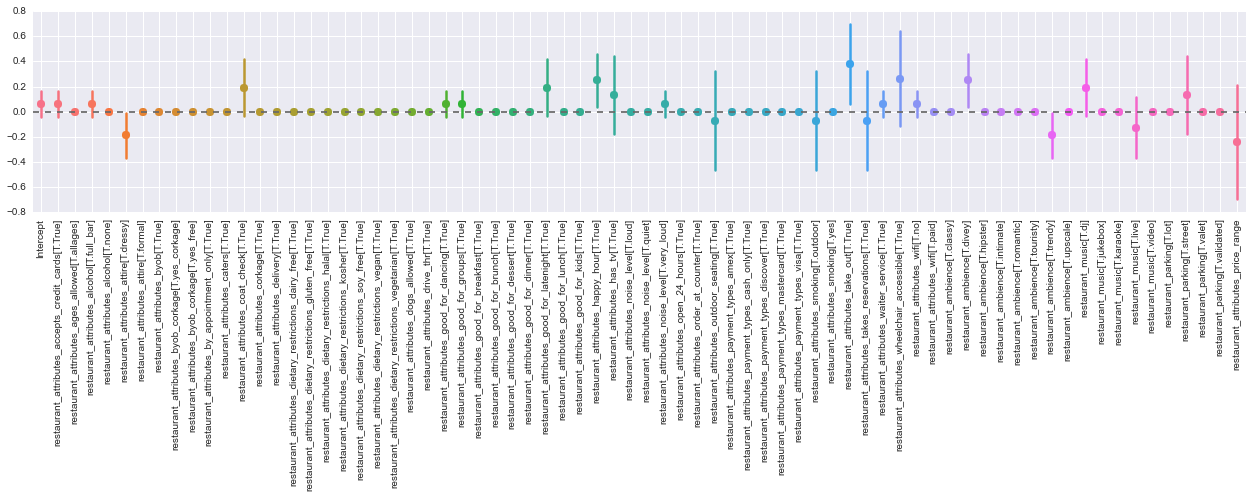

In [154]:
atts = X[['restaurant_attributes_accepts_credit_cards',
 'restaurant_attributes_ages_allowed',
 'restaurant_attributes_alcohol',
 'restaurant_attributes_attire',
 'restaurant_attributes_byob',
 'restaurant_attributes_byob_corkage',
 'restaurant_attributes_by_appointment_only',
 'restaurant_attributes_caters',
 'restaurant_attributes_coat_check',
 'restaurant_attributes_corkage',
 'restaurant_attributes_delivery',
 'restaurant_attributes_dietary_restrictions_dairy_free',
 'restaurant_attributes_dietary_restrictions_gluten_free',
 'restaurant_attributes_dietary_restrictions_halal',
 'restaurant_attributes_dietary_restrictions_kosher',
 'restaurant_attributes_dietary_restrictions_soy_free',
 'restaurant_attributes_dietary_restrictions_vegan',
 'restaurant_attributes_dietary_restrictions_vegetarian',
 'restaurant_attributes_dogs_allowed',
 'restaurant_attributes_drive_thr',
 'restaurant_attributes_good_for_dancing',
 'restaurant_attributes_good_for_groups',
 'restaurant_attributes_good_for_breakfast',
 'restaurant_attributes_good_for_brunch',
 'restaurant_attributes_good_for_dessert',
 'restaurant_attributes_good_for_dinner',
 'restaurant_attributes_good_for_latenight',
 'restaurant_attributes_good_for_lunch',
 'restaurant_attributes_good_for_kids',
 'restaurant_attributes_happy_hour',
 'restaurant_attributes_has_tv',
 'restaurant_attributes_noise_level',
 'restaurant_attributes_open_24_hours',
 'restaurant_attributes_order_at_counter',
 'restaurant_attributes_outdoor_seating',
 'restaurant_attributes_payment_types_amex',
 'restaurant_attributes_payment_types_cash_only',
 'restaurant_attributes_payment_types_discover',
 'restaurant_attributes_payment_types_mastercard',
 'restaurant_attributes_payment_types_visa',
 'restaurant_attributes_price_range',
 'restaurant_attributes_smoking',
 'restaurant_attributes_take_out',
 'restaurant_attributes_takes_reservations',
 'restaurant_attributes_waiter_service',
 'restaurant_attributes_wheelchair_accessible',
 'restaurant_attributes_wifi',
 'restaurant_ambience',
 'restaurant_music',
 'restaurant_parking',]]
sns.mpl.rc("figure", figsize=(14,14))
X_formula = " + ".join([i for i in atts.columns.tolist()])

scores = ['transformed_score', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))


* Formula: transformed_score ~ restaurant_city + restaurant_latitude + restaurant_longitude + restaurant_zipcode

* Formula: score_lvl_1 ~ restaurant_city + restaurant_latitude + restaurant_longitude + restaurant_zipcode

* Formula: score_lvl_2 ~ restaurant_city + restaurant_latitude + restaurant_longitude + restaurant_zipcode

* Formula: score_lvl_3 ~ restaurant_city + restaurant_latitude + restaurant_longitude + restaurant_zipcode


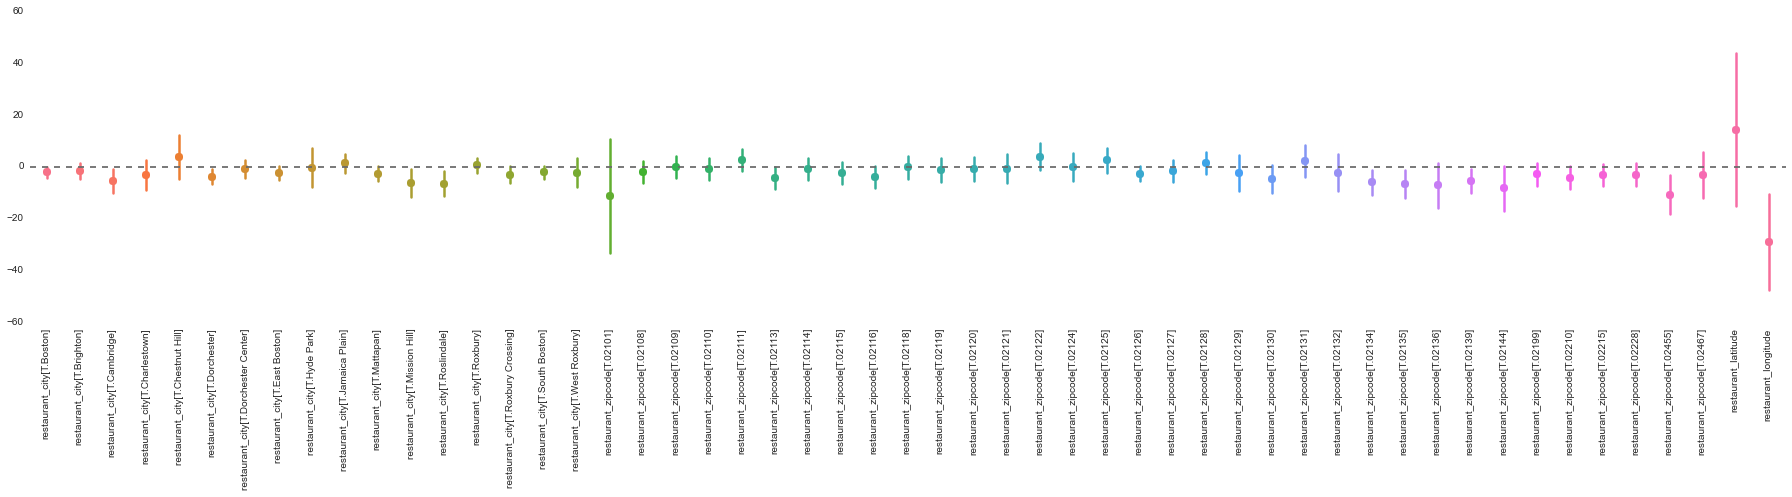

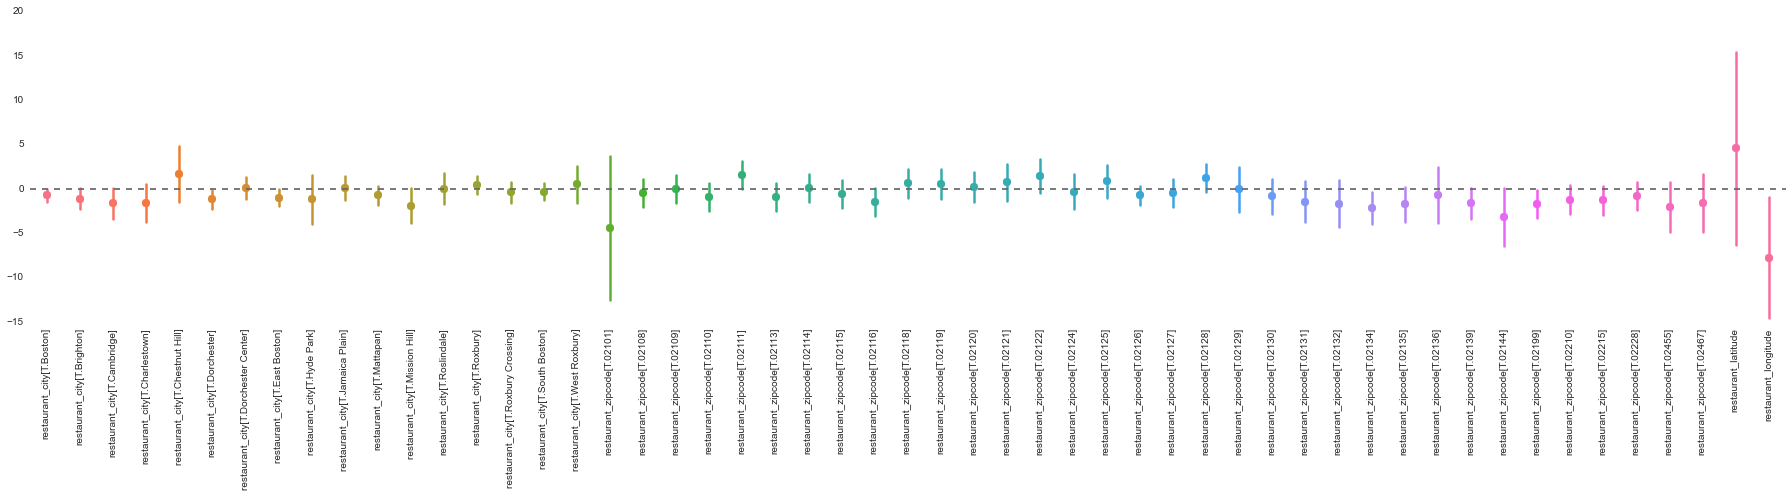

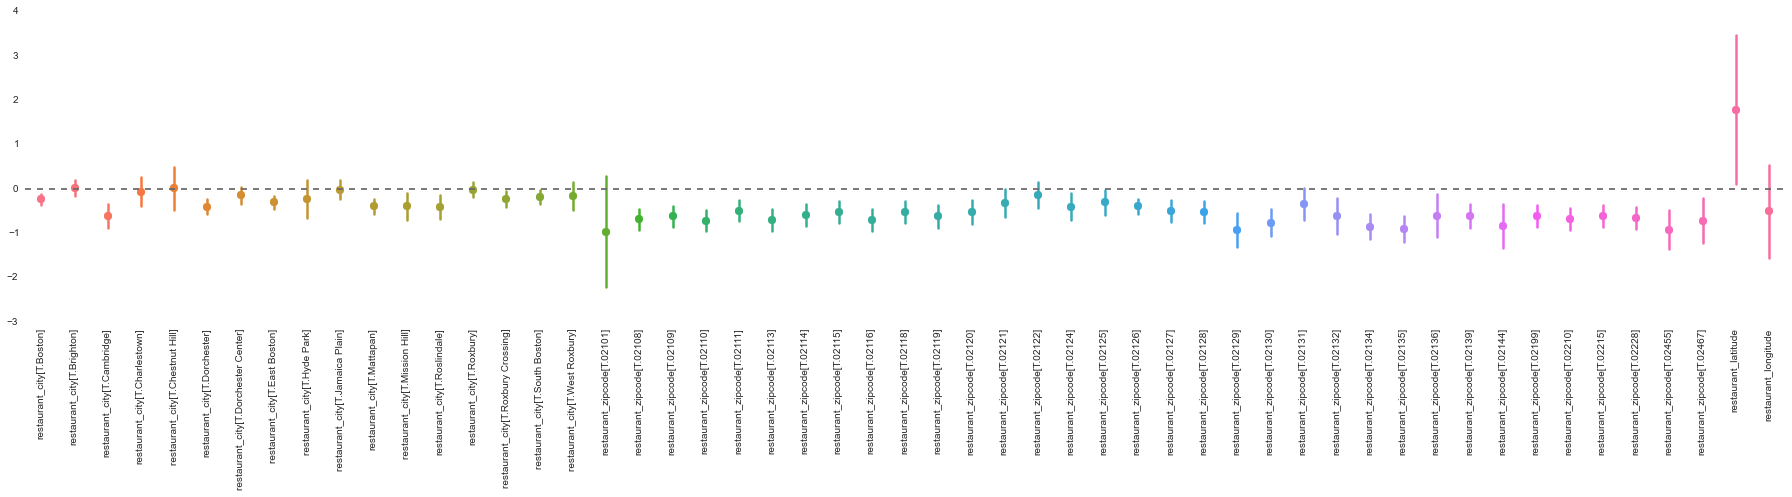

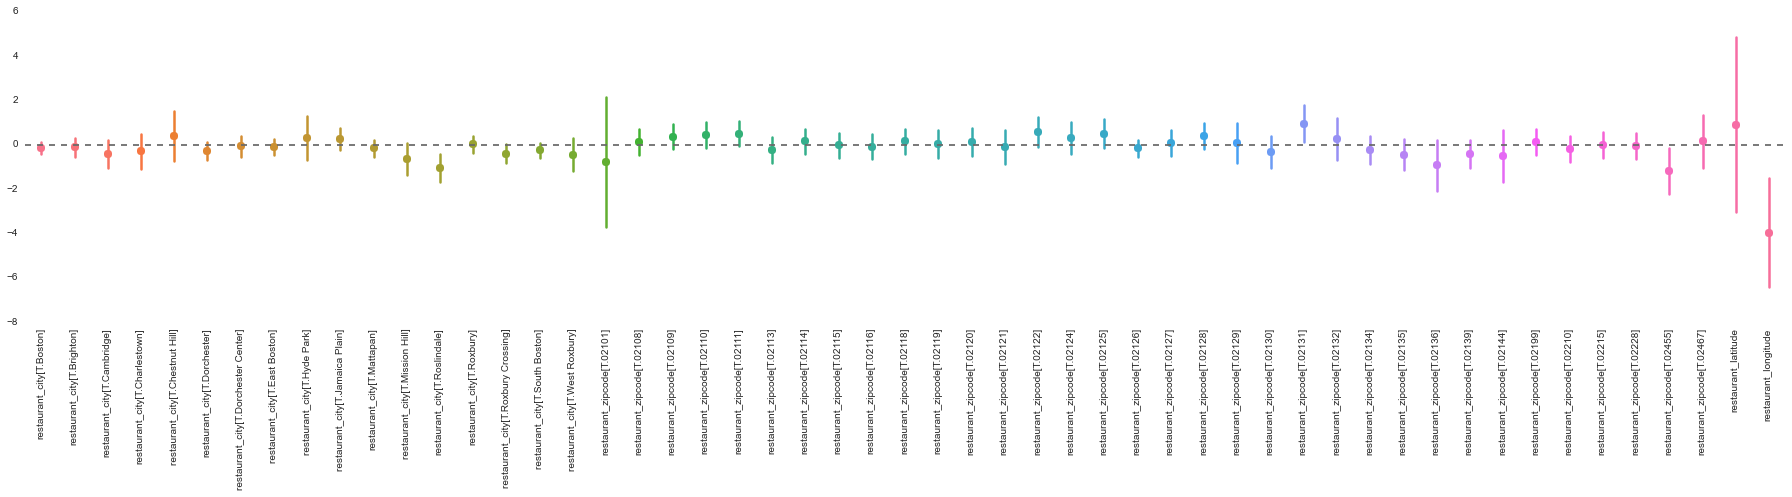

In [277]:
location_attributes = X[[
    'restaurant_city', 'restaurant_latitude',
    'restaurant_longitude', 
#     'restaurant_street',
    'restaurant_zipcode',
]]
sns.mpl.rc("figure", figsize=(20,14))
X_formula = " + ".join([i for i in location_attributes.columns.tolist()])

scores = ['transformed_score', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
#     formula = score + " ~ restaurant_city + restaurant_latitude + restaurant_longitude + C(restaurant_zipcode)"
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=False)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/location_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))


* Formula: score_lvl_1 ~ category

* Formula: score_lvl_2 ~ category

* Formula: score_lvl_3 ~ category


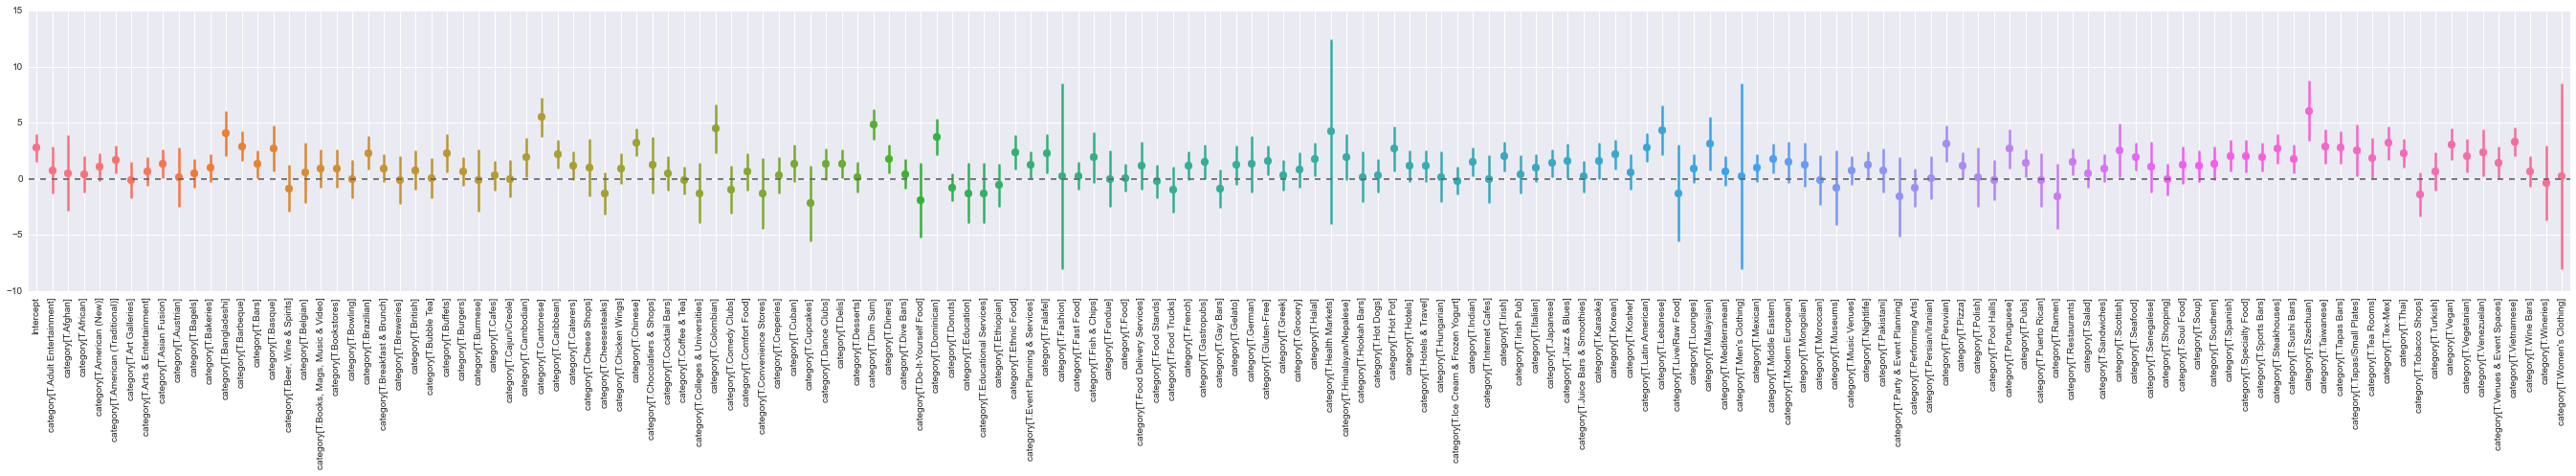

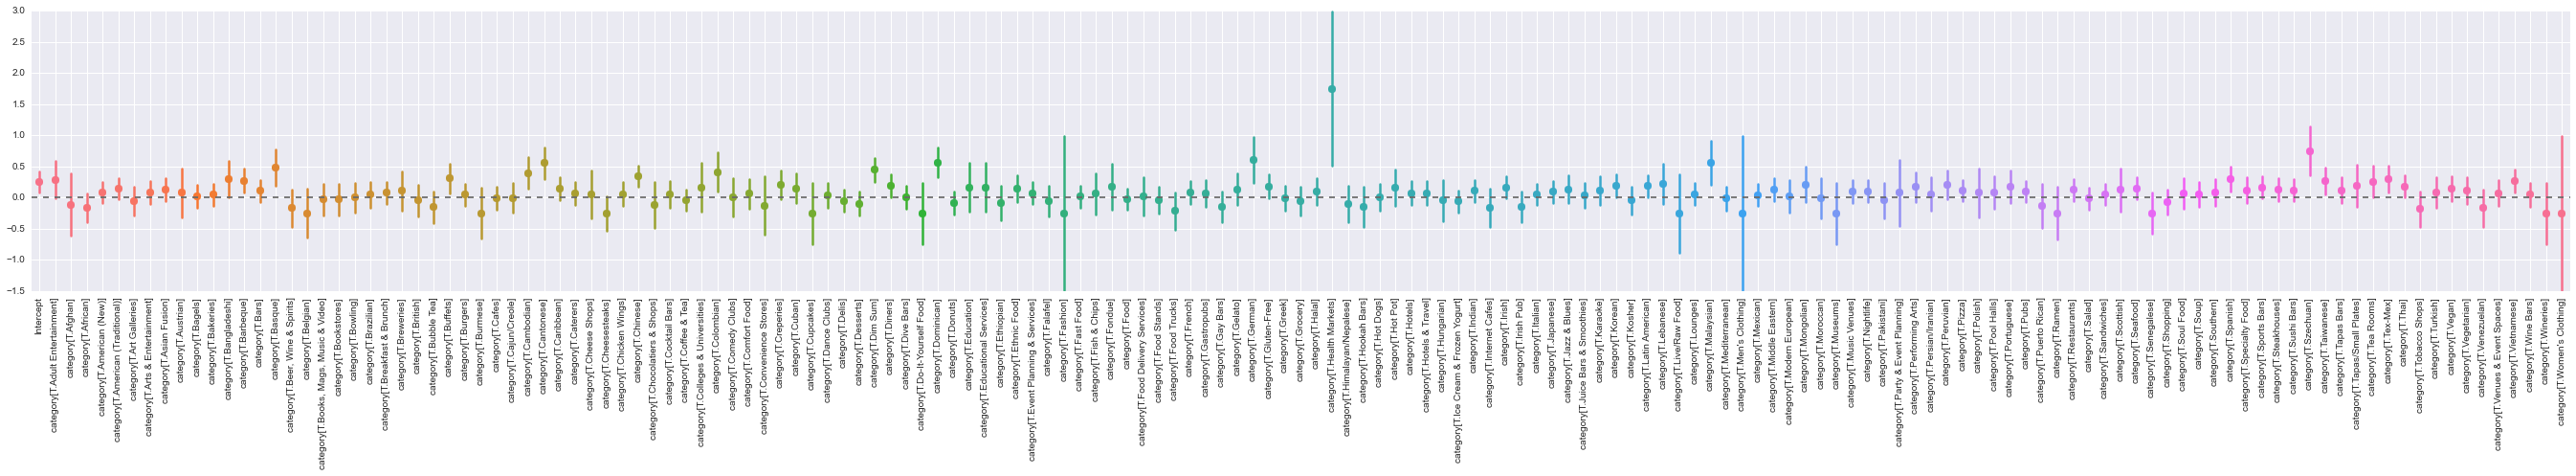

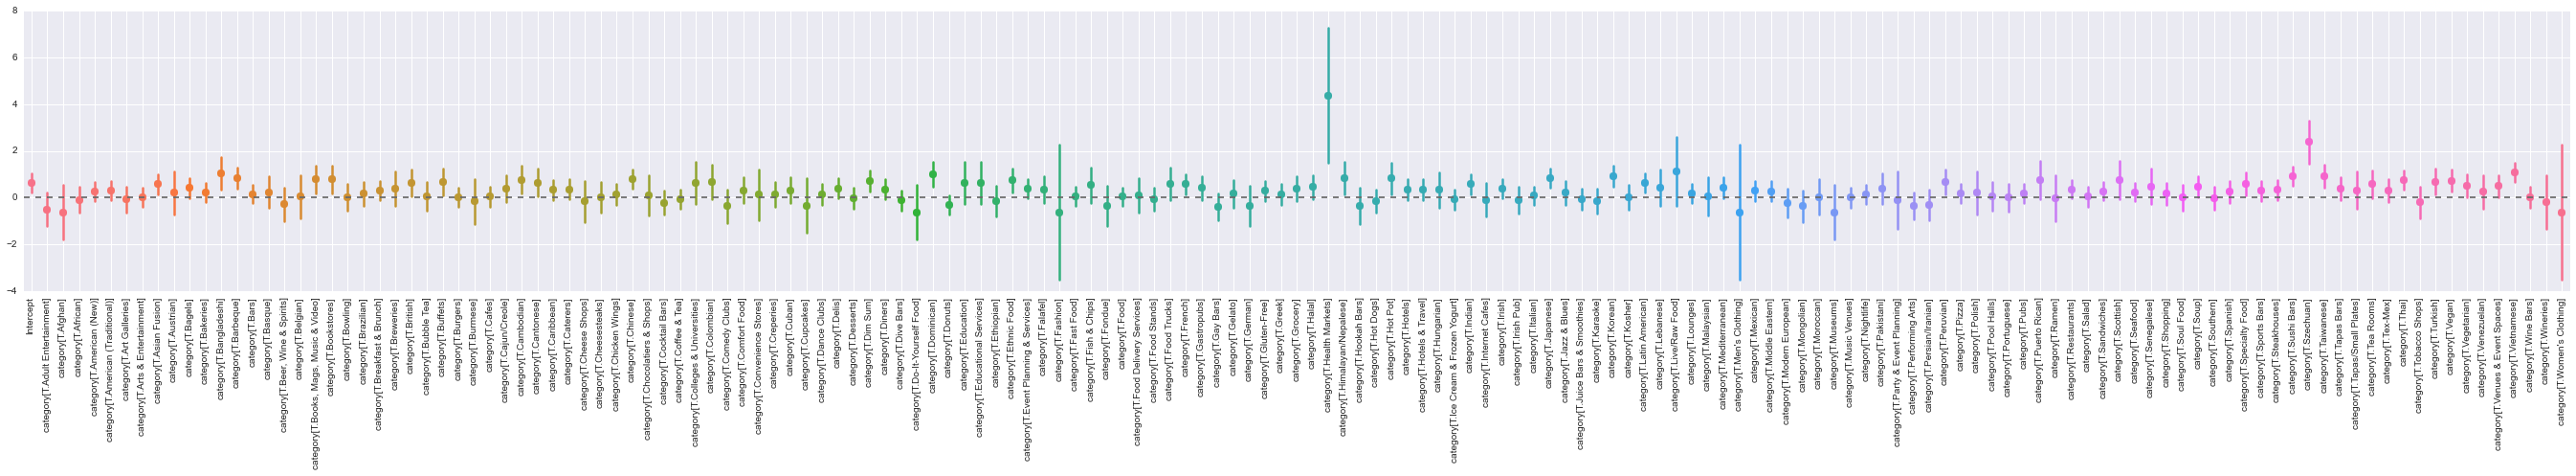

In [110]:
cat = data[['restaurant_category_1',
 'restaurant_category_2',
 'restaurant_category_3',
 'restaurant_category_4',
 'restaurant_category_5',
 'restaurant_category_6',
 'restaurant_category_7','score_lvl_1','score_lvl_2','score_lvl_3']]
new = cat[['restaurant_category_1','score_lvl_1','score_lvl_2','score_lvl_3']]
new.columns = ['category', 'score_lvl_1','score_lvl_2','score_lvl_3']
for i in range(2,8):
    temp = cat[['restaurant_category_'+str(i),'score_lvl_1','score_lvl_2','score_lvl_3']]
    temp.columns = ['category', 'score_lvl_1','score_lvl_2','score_lvl_3']
    new = new.append(temp)
    
sns.mpl.rc("figure", figsize=(30,14))
scores = ['score_lvl_1','score_lvl_2','score_lvl_3']
for score in scores:
    formula = score + " ~ " + 'category'
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, new.dropna().convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_type_coefficients_' + score)
sns.mpl.rc("figure", figsize=(14,10))


* Formula: score_1 ~ neighborhood

* Formula: score_2 ~ neighborhood

* Formula: score_3 ~ neighborhood


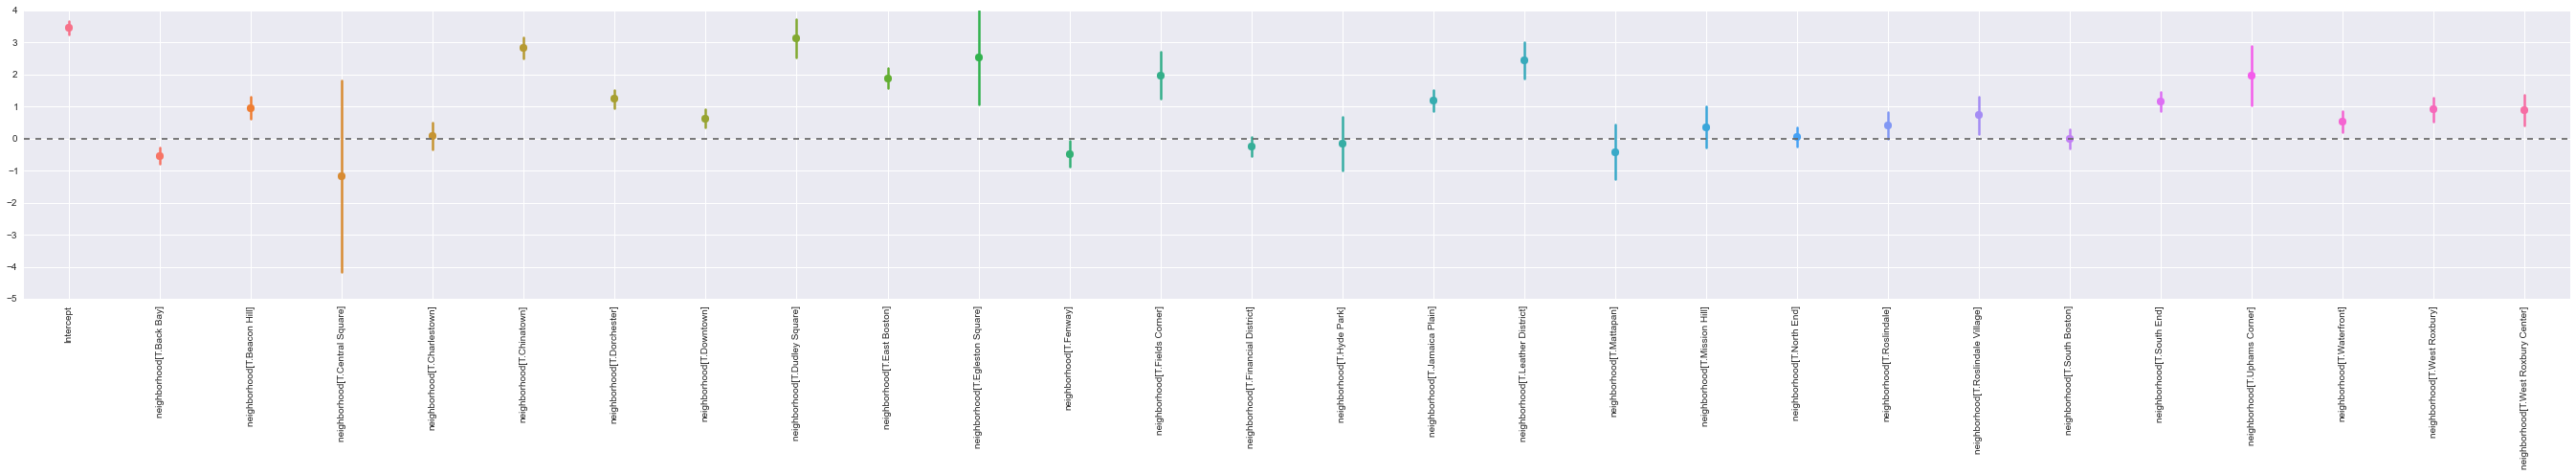

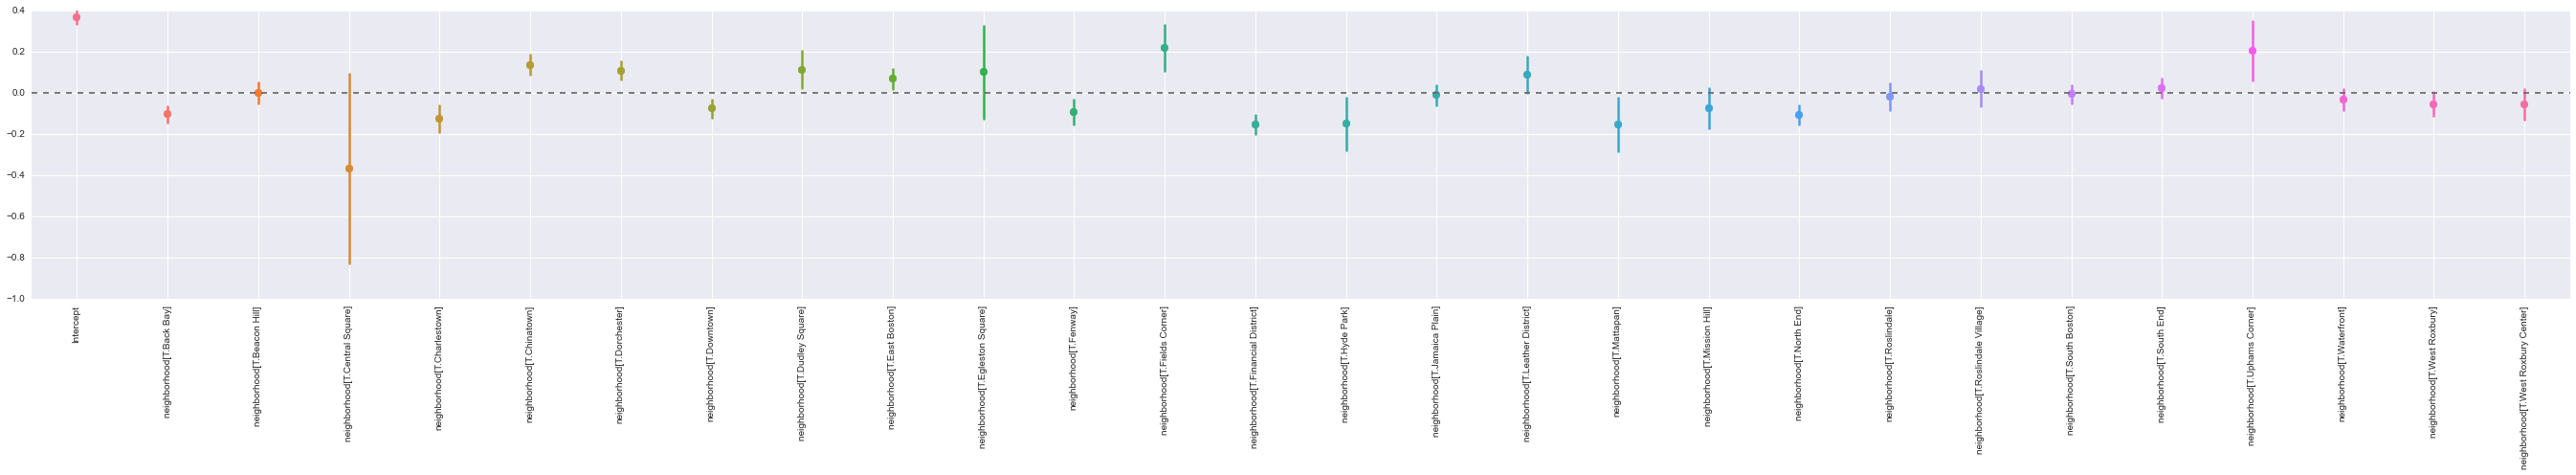

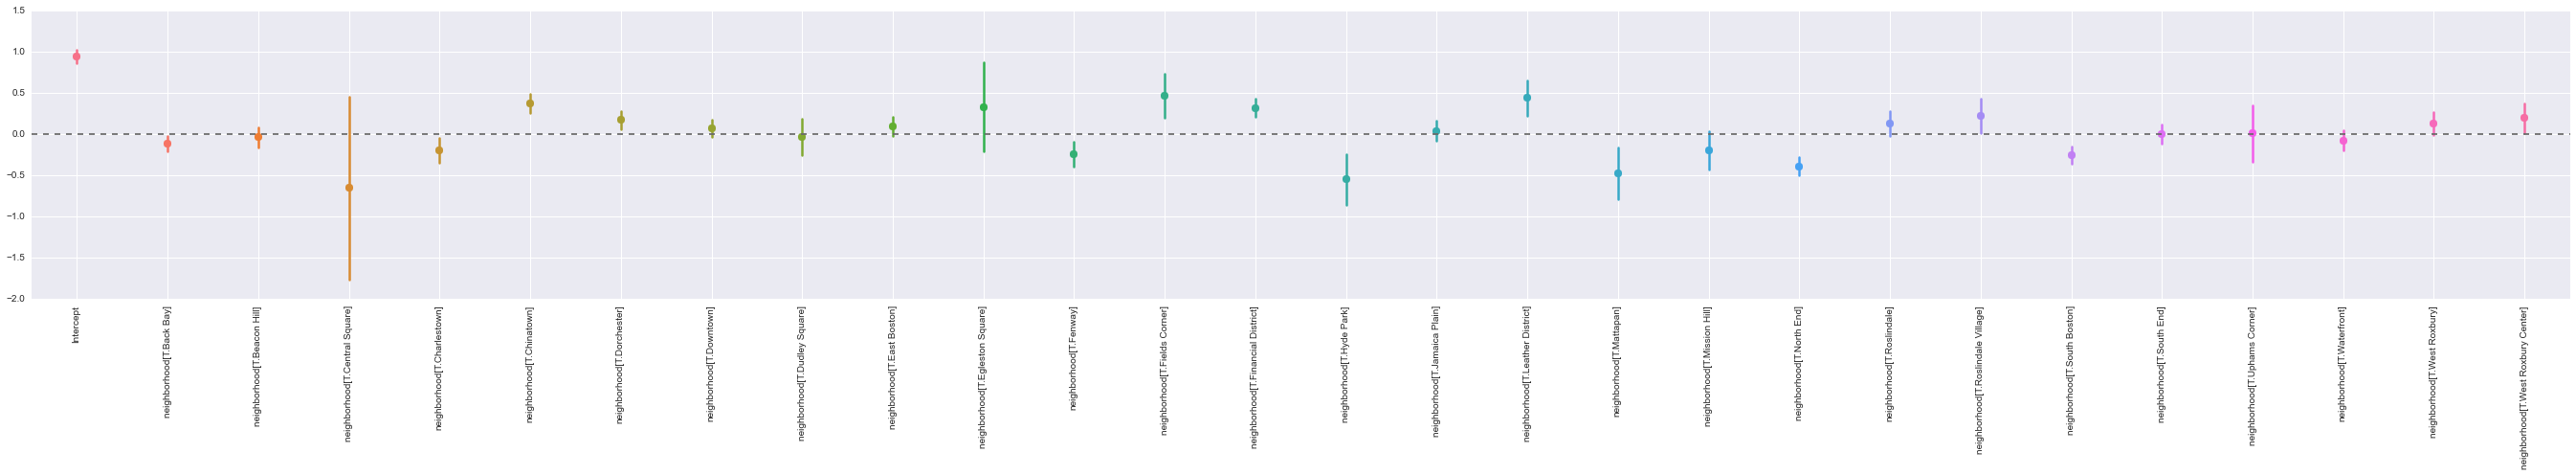

In [93]:
neigh = data[['restaurant_neighborhood_1',
 'restaurant_neighborhood_2',
 'restaurant_neighborhood_3','score_lvl_1','score_lvl_2','score_lvl_3']]
new = neigh[['restaurant_neighborhood_1','score_lvl_1','score_lvl_2','score_lvl_3']]
new.columns = ['neighborhood','score_lvl_1','score_lvl_2','score_lvl_3']
for i in range(2,3):
    temp = neigh[['restaurant_neighborhood_'+str(i),'score_lvl_1','score_lvl_2','score_lvl_3']]
    temp.columns = ['neighborhood','score_lvl_1','score_lvl_2','score_lvl_3']
    new = new.append(temp)
    
sns.mpl.rc("figure", figsize=(30,14))
scores = ['score_lvl_1','score_lvl_2','score_lvl_3']
for score in scores:
    formula = score + " ~ " + 'neighborhood'
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, new.dropna().convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_neighborhood_coefficients_' + score)
sns.mpl.rc("figure", figsize=(14,10))


* Formula: transformed_score ~ C(restaurant_stars) + restaurant_review_count + checkin_counts

* Formula: score_lvl_1 ~ C(restaurant_stars) + restaurant_review_count + checkin_counts

* Formula: score_lvl_2 ~ C(restaurant_stars) + restaurant_review_count + checkin_counts

* Formula: score_lvl_3 ~ C(restaurant_stars) + restaurant_review_count + checkin_counts


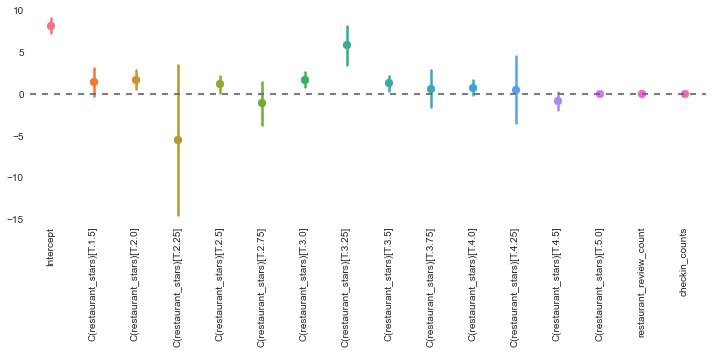

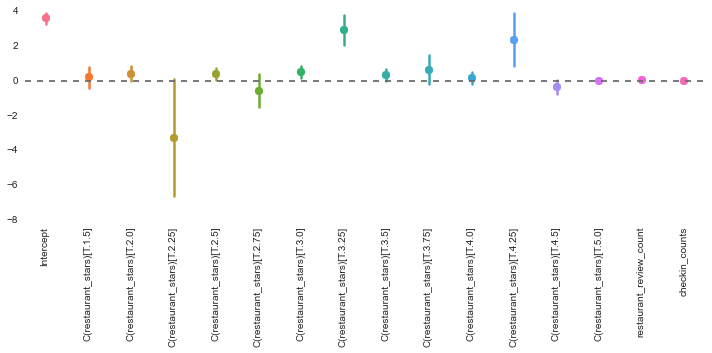

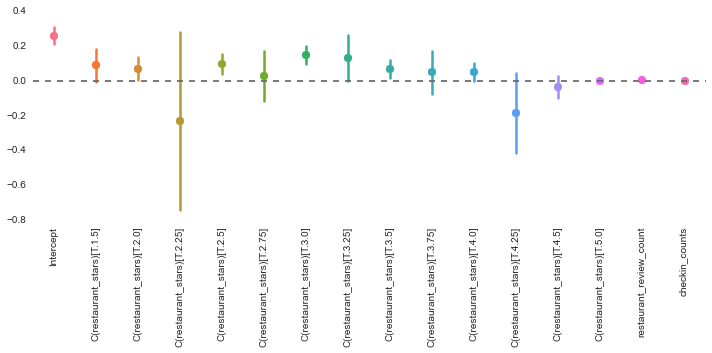

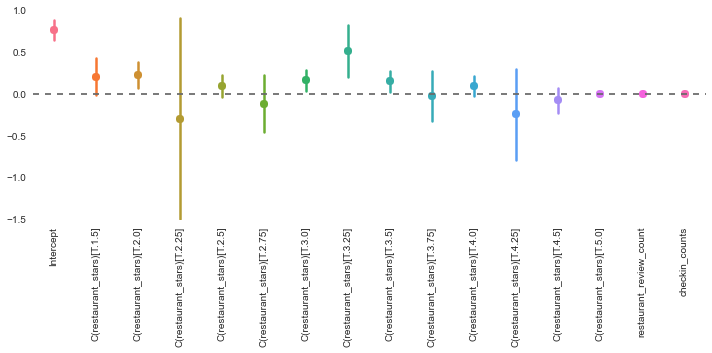

In [280]:
feature_list = ['restaurant_stars', 'restaurant_review_count', 'checkin_counts']

review_attributes = X[feature_list]

sns.mpl.rc("figure", figsize=(8,10))
# X_formula = " * ".join([i for i in selects.columns.tolist()])
X_formula = " + ".join([i for i in review_attributes.columns.tolist()])

scores = ['transformed_score', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
#     formula = score + " ~ " + X_formula
    formula = score + " ~ C(restaurant_stars) + restaurant_review_count + checkin_counts"
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/review_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))

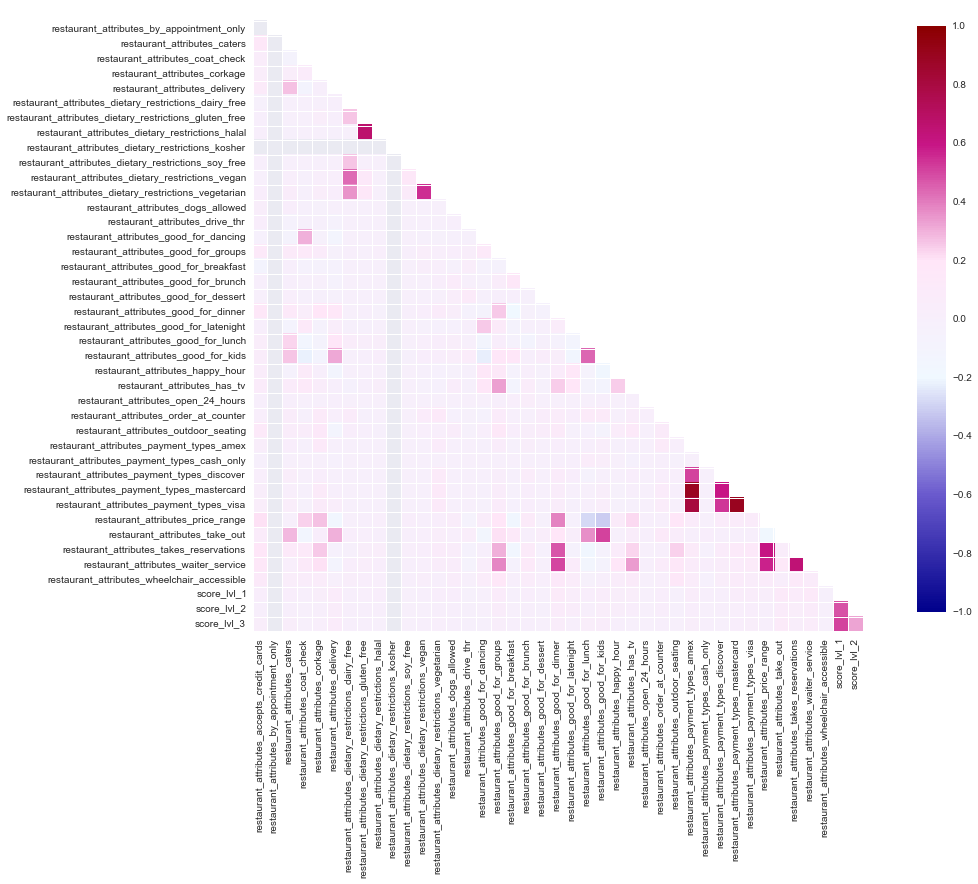

In [99]:
f, ax = plt.subplots(figsize=(14,14))
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                          "#FFE6F8", "#C71585", "#8B0000"], as_cmap=True)
sns.corrplot(pd.concat([atts, y], axis=1), annot=False, diag_names=False, cmap=cmap)
ax.grid(False)

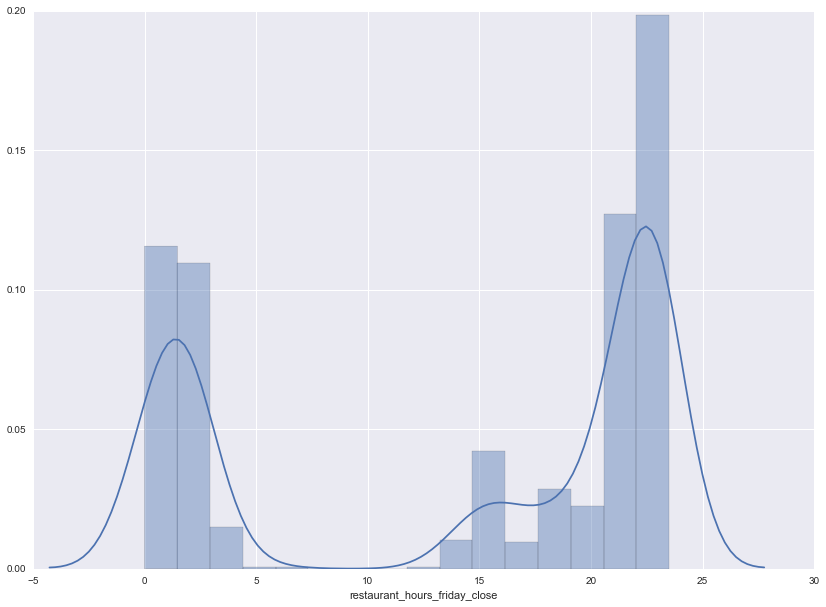

In [167]:
sns.distplot(X.restaurant_hours_friday_close.dropna())

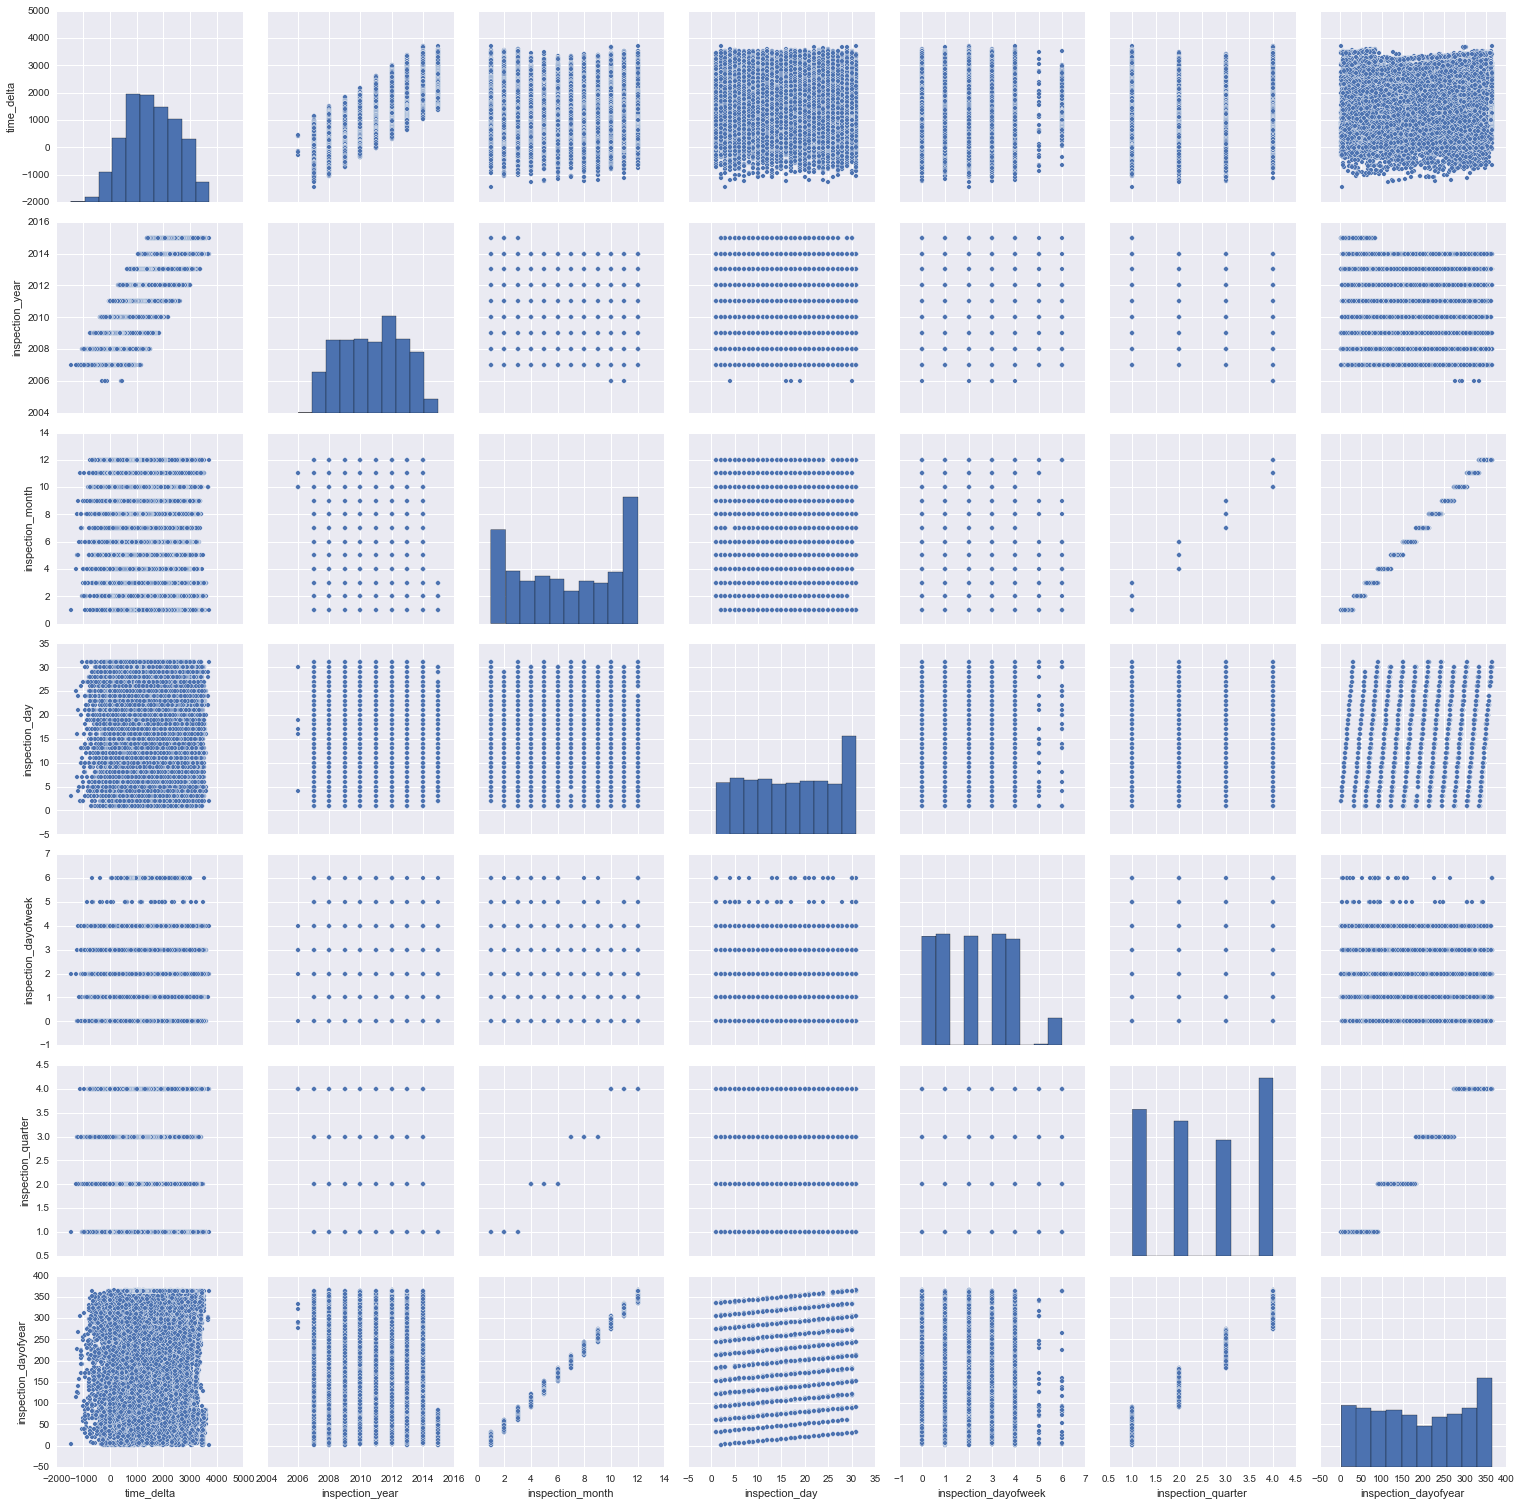

In [115]:
features =[ 'time_delta',
 'inspection_year',
 'inspection_month',
 'inspection_day',
 'inspection_dayofweek',
 'inspection_quarter',
 'inspection_dayofyear']

sns.pairplot(X[features])

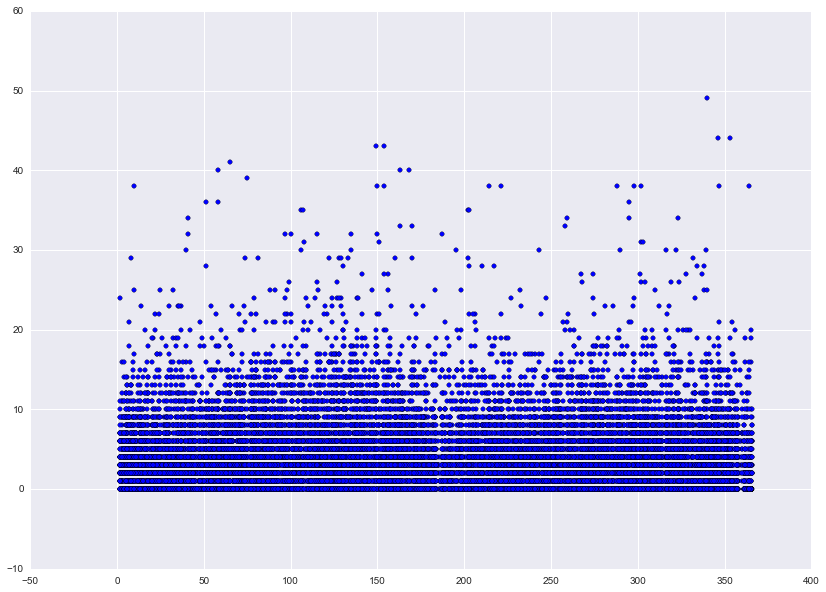

In [166]:
plt.scatter(data['inspection_dayofyear'], data['score_lvl_1'])

In [12]:
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
model_features = ['review_stars']
X, y = extract_features(train_df[model_features + scores])
# X, y = extract_features(pd.get_dummies(new, columns=['category']))
# X, y = extract_features(new)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# set classifiers to test
# estimator = LinearRegression(n_jobs=-1)
# estimator = RandomForestClassifier()
estimator = SGDClassifier(n_jobs=-1)

# can use with text if convert X to dense with .toarray() but is super heavy on ram
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', estimator),
])

for score in scores:
    print(score)
    score_model(X, y[score], pipeline)

print
contest_scoring(X, y, pipeline)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s


score_lvl_1
CV score of 0.114547538658 +/- 0.0541863094737

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s



score_lvl_2
CV score of 0.717033393076 +/- 9.75173421777e-05

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s



score_lvl_3
CV score of 0.540362195558 +/- 0.0274841223629

Contest score of 1.17843981625


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


1.1784398162480336

In [25]:
from nltk.corpus import wordnet as wn
from textblob import Word

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None


def preprocess(text):
    b = TextBlob(unicode(text, 'utf8').strip())
    tags = b.tags
#     tokens = []
#     for tagged in tags:
#         word = Word(tagged[0])
#         if word.isalpha() and word not in stopwords:
#             tag = penn_to_wn(tagged[1])
#             l = word.lemmatize(tag)
#             tokens.append(l.lower())
    tokens = map(preprocess2, tags)
    return ' '.join(filter(None, tokens))


def sentiments(text):
    b = TextBlob(unicode(text, 'utf8').strip())
    sentiment = lambda x: tuple(x.sentiment)
    return map(sentiment, b.sentences)

def preprocess2(tagged):
    word = Word(tagged[0])
    if word.isalpha() and word not in stopwords:
        tag = penn_to_wn(tagged[1])
        l = word.lemmatize(tag)
    else:
        l = ''
    return l.lower()


In [59]:
df = pd.read_pickle('pickle_jar/review_text_sentiment_for_all_reviews_df')

In [60]:
df['polarity'] = df.sentiment.apply(lambda x: x[0])
df['subjectivity'] = df.sentiment.apply(lambda x: x[1])

In [65]:
y.score_lvl_1.shape

(27088,)

In [19]:
from sklearn.externals import joblib

tfidf = joblib.load('pickle_jar/tfidf_preprocessed_ngram3_sublinear')

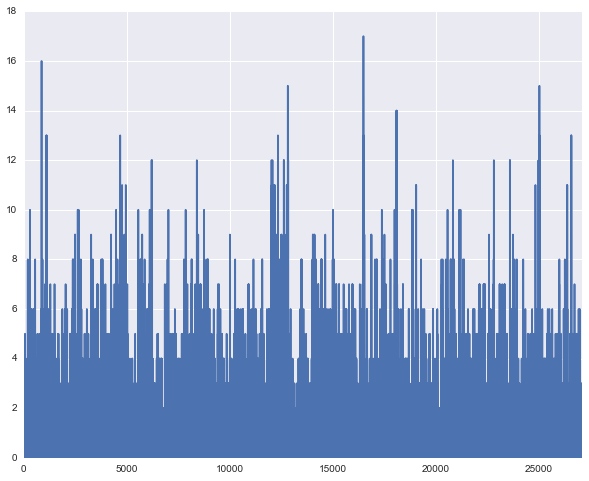

In [47]:
single = train_df[train_df.restaurant_id == '0ZEDGWOD'][['inspection_date', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']].sort('inspection_date')
sns.tsplot(train_df.set_index('inspection_date')['score_lvl_3'])

In [108]:
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
model_features = ['subjectivity']
X, y = extract_features(df[model_features + scores])
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


# set classifiers to test
# estimator = LinearRegression()
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)
# estimator = SGDClassifier(n_jobs=-1, random_state=42)
# estimator = BaggingClassifier(random_state=42)

# can use with text if convert X to dense with .toarray() but is super heavy on ram
pipeline = Pipeline([
#         ('normalizer', Normalizer()),
        ('scaler', StandardScaler()),
        ('clf', estimator),
])

for score in scores:
    print(score)
    score_model(X, y[score], pipeline)

print
contest_scoring(X, y, pipeline)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


score_lvl_1
CV score of 0.119359539973 +/- 0.00595426468993

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished



score_lvl_2
CV score of 0.594027958682 +/- 0.0115416807706

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished



score_lvl_3
CV score of 0.4060866651 +/- 0.00748583936945

Contest score of 1.43463389992


1.4346338999153438

In [101]:
X

,polarity
0,0.146047
1,0.160297
2,0.192274
3,0.232951
4,0.239858
5,0.184290
6,0.105816
7,0.223597
8,0.232951
9,0.214841
